# Taller 9

### Aprendizaje en Redes Bayesianas: Estructura

##### Analítica Computacional para la Toma de Decisiones

---

|     Nombres      |      Apellidos       |     Login     |  Codigo   |
| :--------------: | :------------------: | :-----------: | :-------: |
|     Santiago     | Gonzalez Montealegre | s.gonzalez35  | 202012274 |
| Juliana Carolina |  Cardenas Barragan   | jc.cardenasb1 | 202011683 |

## Ahora con otra Red y Datos

## Librerías Requeridas

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from pgmpy.estimators import PC
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import K2Score
from pgmpy.estimators import BicScore

### 1 - Carga de Datos

In [2]:
def annual_growth(row, years):
    min_year = years["min"]
    max_year = years["max"]
    row["Indicator Name"] = row["Indicator Name"] + " - [annual growth %]"
    
    for year in range(max_year, min_year, -1):
        
        if not np.isnan(row[str(year)]) and not np.isnan(row[str(year - 1)]):
            row[str(year)] = 100 * (float(row[str(year)]) - float(row[str(year - 1)])) / abs(float(row[str(year - 1)]))
            
        else:
            row[str(year)] = np.nan
            row[str(min_year)] = np.nan
    return row

years = {"min" : 1960, "max" : 2019}
df_raw = pd.read_csv("../Data/italy-raw-data.csv")

df_raw_growth = pd.DataFrame(data=[row if "growth" in row["Indicator Name"] else annual_growth(row, years) for index, row in df_raw.iterrows()])

print("There are " + str(df_raw_growth.shape[0]) + " indicators in the dataframe.")
df_raw_growth.head()

There are 10 indicators in the dataframe.


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Italy,ITA,Population growth (annual %),SP.POP.GROW,1.993928,0.668383,0.676623,0.729553,0.822624,0.842109,...,0.307591,0.171978,0.269541,1.159251,0.917504,-0.096376,-0.169884,-0.149861,-0.190064,NaN
1,Italy,ITA,Urban population growth (annual %),SP.URB.GROW,2.836401,1.498807,1.506833,1.551287,1.636027,1.642485,...,0.480439,0.343066,0.619579,1.587835,1.341371,0.325701,0.246127,0.262999,0.228198,NaN
2,Italy,ITA,GDP per capita growth (annual %),NY.GDP.PCAP.KD.ZG,NaN,7.486419,5.487478,4.842052,1.955533,2.402046,...,1.400915,0.534287,-3.242060,-2.972404,-0.917814,0.875477,1.451875,1.868715,0.966058,NaN
3,Italy,ITA,Energy use (kg of oil equivalent per capita) -...,EG.USE.PCAP.KG.OE,NaN,NaN,13.064053,11.188621,9.110076,7.753922,...,2.113919,-3.486796,-4.211107,-4.791839,-6.396212,2.786129,NaN,NaN,NaN,NaN
4,Italy,ITA,Fossil fuel energy consumption (% of total) - ...,EG.USE.COMM.FO.ZS,NaN,NaN,1.933224,-0.167728,1.075163,-0.074481,...,-0.262284,-0.193760,-2.679745,-2.721392,-1.723158,1.733165,NaN,NaN,NaN,NaN


In [17]:
df_raw.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Italy,ITA,Population growth (annual %),SP.POP.GROW,1.993928,0.668383,0.676623,0.729553,0.822624,0.842109,...,0.307591,0.171978,0.269541,1.159251,0.917504,-0.096376,-0.169884,-0.149861,-0.190064,NaN
1,Italy,ITA,Urban population growth (annual %),SP.URB.GROW,2.836401,1.498807,1.506833,1.551287,1.636027,1.642485,...,0.480439,0.343066,0.619579,1.587835,1.341371,0.325701,0.246127,0.262999,0.228198,NaN
2,Italy,ITA,GDP per capita growth (annual %),NY.GDP.PCAP.KD.ZG,NaN,7.486419,5.487478,4.842052,1.955533,2.402046,...,1.400915,0.534287,-3.242060,-2.972404,-0.917814,0.875477,1.451875,1.868715,0.966058,NaN
3,Italy,ITA,Energy use (kg of oil equivalent per capita),EG.USE.PCAP.KG.OE,794.816045,890.688346,1007.048347,1119.723172,1221.730806,1316.462854,...,2930.588524,2828.404891,2709.297728,2579.472543,2414.484002,2481.754645,NaN,NaN,NaN,NaN
4,Italy,ITA,Fossil fuel energy consumption (% of total),EG.USE.COMM.FO.ZS,85.610421,87.617145,89.310980,89.161181,90.119809,90.052687,...,84.628774,84.464797,82.201356,79.964335,78.586423,79.948455,NaN,NaN,NaN,NaN


### 2 - Extraer Columnas

In [3]:
nodes = ['Pop', 'Urb', 'GDP', 'EC', 'FFEC', 'REC', 'EI', 'CO2', 'CH4', 'N2O']
df_growth = df_raw_growth.transpose().iloc[4:]
df_growth.columns = nodes
df_growth.head()

,Pop,Urb,GDP,EC,FFEC,REC,EI,CO2,CH4,N2O
1960,1.993928,2.836401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961,0.668383,1.498807,7.486419,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962,0.676623,1.506833,5.487478,13.064053,1.933224,NaN,5.753948,17.588694,NaN,NaN
1963,0.729553,1.551287,4.842052,11.188621,-0.167728,NaN,2.519427,12.51158,NaN,NaN
1964,0.822624,1.636027,1.955533,9.110076,1.075163,NaN,0.631028,6.78298,NaN,NaN


### 3 - Transformar Variables

In [4]:
TIERS_NUM = 3

def boundary_str(start, end, tier):
    return f'{tier}: {start:+0,.2f} to {end:+0,.2f}'

def relabel_value(v, boundaries):
    if v >= boundaries[0][0] and v <= boundaries[0][1]:
        return boundary_str(boundaries[0][0], boundaries[0][1], tier='A')
    elif v >= boundaries[1][0] and v <= boundaries[1][1]:
        return boundary_str(boundaries[1][0], boundaries[1][1], tier='B')
    elif v >= boundaries[2][0] and v <= boundaries[2][1]:
        return boundary_str(boundaries[2][0], boundaries[2][1], tier='C')
    else:
        return np.nan

def relabel(values, boundaries):
    result = []
    for v in values:
        result.append(relabel_value(v, boundaries))
    return result

def get_boundaries(tiers):
    prev_tier = tiers[0]
    boundaries = [(prev_tier[0], prev_tier[prev_tier.shape[0] - 1])]
    for index, tier in enumerate(tiers):
        if index != 0:
            boundaries.append((prev_tier[prev_tier.shape[0] - 1], tier[tier.shape[0] - 1]))
            prev_tier = tier
    return boundaries

new_columns = {}
for i, content in enumerate(df_growth.items()):
    (label, series) = content
    values = np.sort(np.array([x for x in series.tolist() if not np.isnan(x)] , dtype=float))
    if values.shape[0] < TIERS_NUM:
        print(f'Error: there are not enough data for label {label}')
        break
    boundaries = get_boundaries(tiers=np.array_split(values, TIERS_NUM))
    new_columns[label] = relabel(series.tolist(), boundaries)

df = pd.DataFrame(data=new_columns)
df.columns = nodes
df.index = range(years["min"], years["max"] + 1)

df.head(10)

,Pop,Urb,GDP,EC,FFEC,REC,EI,CO2,CH4,N2O
1960,C: +0.50 to +1.99,C: +0.82 to +2.84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961,C: +0.50 to +1.99,C: +0.82 to +2.84,C: +2.89 to +7.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962,C: +0.50 to +1.99,C: +0.82 to +2.84,C: +2.89 to +7.49,C: +2.77 to +13.06,C: +0.15 to +2.11,NaN,C: +0.73 to +5.75,C: +3.81 to +17.59,NaN,NaN
1963,C: +0.50 to +1.99,C: +0.82 to +2.84,C: +2.89 to +7.49,C: +2.77 to +13.06,B: -0.44 to +0.15,NaN,C: +0.73 to +5.75,C: +3.81 to +17.59,NaN,NaN
1964,C: +0.50 to +1.99,C: +0.82 to +2.84,B: +1.24 to +2.89,C: +2.77 to +13.06,C: +0.15 to +2.11,NaN,B: -0.40 to +0.73,C: +3.81 to +17.59,NaN,NaN
1965,C: +0.50 to +1.99,C: +0.82 to +2.84,B: +1.24 to +2.89,C: +2.77 to +13.06,B: -0.44 to +0.15,NaN,C: +0.73 to +5.75,C: +3.81 to +17.59,NaN,NaN
1966,C: +0.50 to +1.99,C: +0.82 to +2.84,C: +2.89 to +7.49,C: +2.77 to +13.06,C: +0.15 to +2.11,NaN,C: +0.73 to +5.75,C: +3.81 to +17.59,NaN,NaN
1967,C: +0.50 to +1.99,C: +0.82 to +2.84,C: +2.89 to +7.49,C: +2.77 to +13.06,C: +0.15 to +2.11,NaN,C: +0.73 to +5.75,C: +3.81 to +17.59,NaN,NaN
1968,C: +0.50 to +1.99,C: +0.82 to +2.84,C: +2.89 to +7.49,C: +2.77 to +13.06,C: +0.15 to +2.11,NaN,C: +0.73 to +5.75,C: +3.81 to +17.59,NaN,NaN
1969,C: +0.50 to +1.99,C: +0.82 to +2.84,C: +2.89 to +7.49,C: +2.77 to +13.06,C: +0.15 to +2.11,NaN,B: -0.40 to +0.73,C: +3.81 to +17.59,NaN,NaN


### 4 - Estime Estructura del Modelo: Restricciones

In [5]:
est = PC(data=df)
estimated_model_constraints = est.estimate(variant="stable", max_cond_vars=4)

  0%|          | 0/4 [00:00<?, ?it/s]

In [6]:
print(estimated_model_constraints)
print(estimated_model_constraints.nodes())
print(estimated_model_constraints.edges())

DAG with 4 nodes and 2 edges
['Pop', 'Urb', 'EC', 'CO2']
[('Urb', 'Pop'), ('CO2', 'EC')]


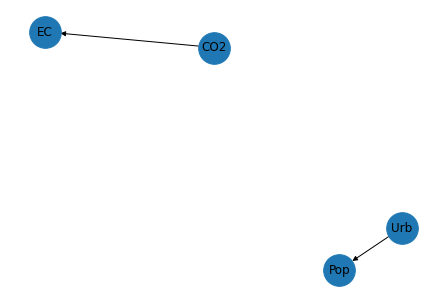

In [7]:
nodes = list(estimated_model_constraints.nodes())
edges = list(estimated_model_constraints.edges())

# Create Graph
G = nx.DiGraph()

# Add Nodes
for node in nodes:
    G.add_node(node)
    
# Add Edges
for edge in edges:
    G.add_edge(edge[0], edge[1])
    
# Draw Graph
pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_size=1000, arrows=True)
plt.show()

### 5 - Estime Estructura del Modelo: Puntaje

In [8]:
scoring_method = K2Score(data=df)
esth = HillClimbSearch(data=df)

estimated_model_k2 = esth.estimate(
    scoring_method=scoring_method,
    max_indegree=4,
    max_iter=int(1e4)
    )

  0%|          | 0/10000 [00:00<?, ?it/s]

In [9]:
print(estimated_model_k2)
print(estimated_model_k2.nodes())
print(estimated_model_k2.edges())

DAG with 10 nodes and 10 edges
['Pop', 'Urb', 'GDP', 'EC', 'FFEC', 'REC', 'EI', 'CO2', 'CH4', 'N2O']
[('Pop', 'FFEC'), ('Urb', 'Pop'), ('EC', 'N2O'), ('FFEC', 'REC'), ('FFEC', 'N2O'), ('REC', 'CH4'), ('EI', 'GDP'), ('CO2', 'EC'), ('CO2', 'EI'), ('CH4', 'CO2')]


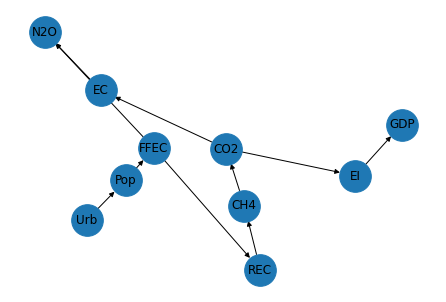

In [21]:
nodes = list(estimated_model_k2.nodes())
edges = list(estimated_model_k2.edges())

# Create Graph
G = nx.DiGraph()

# Add Nodes
for node in nodes:
    G.add_node(node)
    
# Add Edges
for edge in edges:
    G.add_edge(edge[0], edge[1])
    
# Draw Graph
pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_size=1000, arrows=True)
plt.show()

### 6 - Modelo Propuesto Lorenzo

In [23]:
model = BayesianNetwork([
    ('Pop', 'EC'),
    ('Urb', 'EC'),
    ('GDP', 'EC'),
    ('EC', 'FFEC'),
    ('EC', 'REC'),
    ('EC', 'EI'),
    ('REC', 'CO2'),
    ('REC', 'CH4'),
    ('REC', 'N2O'),
    ('FFEC', 'CO2'),
    ('FFEC', 'CH4'),
    ('FFEC', 'N2O'),
    ])

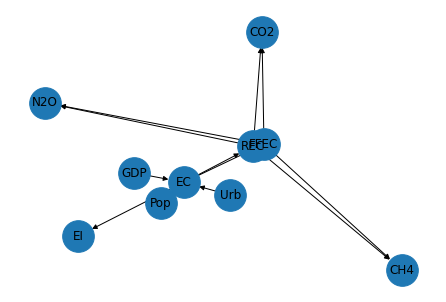

In [44]:
nodes = list(model.nodes())
edges = list(model.edges())

# Create Graph
G = nx.DiGraph()

# Add Nodes
for node in nodes:
    G.add_node(node)
    
# Add Edges
for edge in edges:
    G.add_edge(edge[0], edge[1])
    
# Draw Graph
# pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_size=1000, arrows=True)
plt.show()